In [1]:
%%capture 
%run "./shared.ipynb"

# Definition of state-of-the-art model for LGG vs HGG classification

In [2]:
from python.shared.model_keras import initialize_slicenet_model, initialize_slicenet_model_2
from python.shared.data_utils import LggHggGenerator
from tensorflow import keras

In [3]:
batch_size = 32
epochs = 20
IMG_HEIGHT = 240
IMG_WIDTH = 240

In [4]:
train_dir = '../data/train/confidence_19/'
seg_train_dir = '../data/train/seg_confidence_19/'
val_dir = '../data/valid/confidence_19/'
seg_val_dir = '../data/valid/seg_confidence_19/'
test_dir = '../data/test/confidence_19/'
seg_test_dir = '../data/test/seg_confidence_19/'

train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range=10,
                                           width_shift_range=0.0,
                                           height_shift_range=0.0,
                                           horizontal_flip=True,
                                           vertical_flip=True)
train_seg_generator = ImageDataGenerator(rotation_range=10,
                                         width_shift_range=0.0,
                                           height_shift_range=0.0,
                                           horizontal_flip=True,
                                           vertical_flip=True)
val_image_generator = ImageDataGenerator(rescale=1./255)
val_seg_generator = ImageDataGenerator()

lgg_hgg_generator = LggHggGenerator(train_image_generator, train_seg_generator, train_dir, seg_train_dir)
val_lgg_hgg_generator = LggHggGenerator(val_image_generator, val_seg_generator, val_dir, seg_val_dir)
test_lgg_hgg_generator = LggHggGenerator(val_image_generator, val_seg_generator, test_dir, seg_test_dir)

In [5]:
train_image_gen = lgg_hgg_generator.get_image_generator(batch_size, True)
train_seg_gen = lgg_hgg_generator.get_seg_generator(batch_size, True)
val_image_gen = val_lgg_hgg_generator.get_image_generator(batch_size)
val_seg_gen = val_lgg_hgg_generator.get_seg_generator(batch_size)
test_image_gen = test_lgg_hgg_generator.get_image_generator(batch_size, True)
test_seg_gen = test_lgg_hgg_generator.get_seg_generator(batch_size, True)

Found 1645 images belonging to 2 classes.
Found 1645 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [6]:
x, y = next(val_image_gen)
x_seg, y_seg = next(val_seg_gen)

(32, 240, 240, 3)


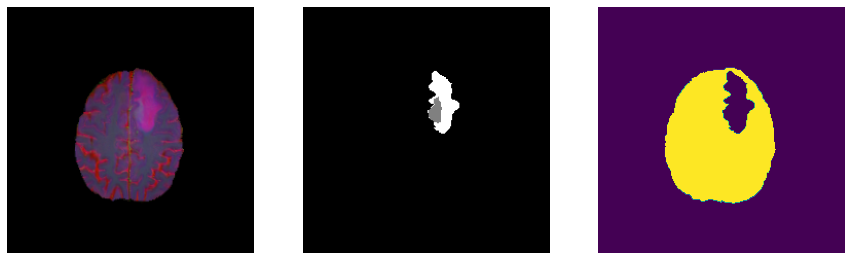

In [8]:
print(x.shape)
i = 11
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
visualization.plot_rgb(x[i], ax= axes[0])
visualization.plot_gray(x_seg[i], ax= axes[1])
visualization.plot_rgb(mask_utils.get_mask_of_brain(x[i], mask_utils.get_mask_of_seg(x_seg[i]).squeeze()), ax= axes[2])

In [9]:
model = initialize_slicenet_model_2(IMG_HEIGHT, IMG_WIDTH)

In [10]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.8),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
history = model.fit(
  train_image_gen,
  validation_data=val_image_gen,
  epochs=epochs
)

Train for 52 steps, validate for 14 steps
Epoch 1/20
52/52 [==============================] - 36s 691ms/step - loss: 0.6855 - accuracy: 0.5520 - val_loss: 0.6834 - val_accuracy: 0.6368
Epoch 2/20
52/52 [==============================] - 35s 668ms/step - loss: 0.6481 - accuracy: 0.6736 - val_loss: 0.6423 - val_accuracy: 0.6502
Epoch 3/20
52/52 [==============================] - 35s 679ms/step - loss: 0.5934 - accuracy: 0.6711 - val_loss: 0.6151 - val_accuracy: 0.5695
Epoch 4/20
52/52 [==============================] - 35s 677ms/step - loss: 0.5544 - accuracy: 0.7040 - val_loss: 0.7081 - val_accuracy: 0.5852
Epoch 5/20
52/52 [==============================] - 35s 670ms/step - loss: 0.5450 - accuracy: 0.7076 - val_loss: 0.5857 - val_accuracy: 0.6928
Epoch 6/20
52/52 [==============================] - 35s 676ms/step - loss: 0.5464 - accuracy: 0.7076 - val_loss: 0.6376 - val_accuracy: 0.6726
Epoch 7/20
52/52 [==============================] - 35s 665ms/step - loss: 0.5093 - accuracy: 0.7350

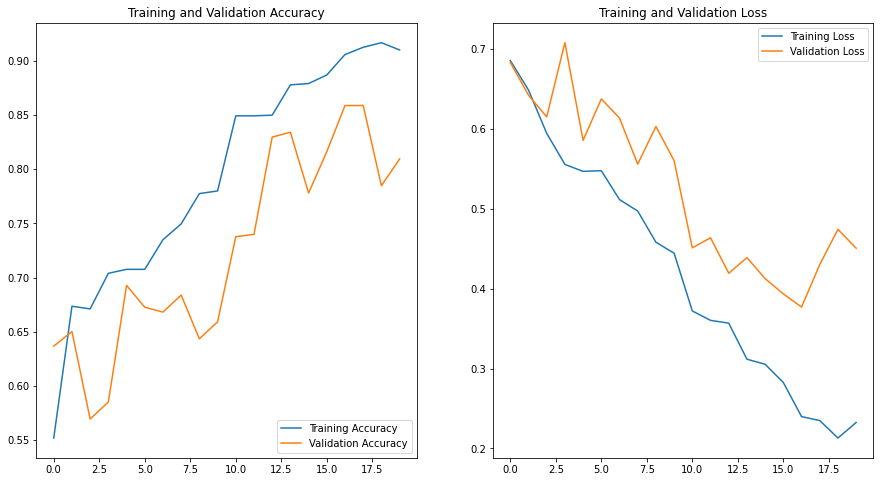

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
def evaluate_model(model, val_image_gen):  
    y_true_v = []
    pred_v = []
    iterations = val_image_gen.samples / batch_size
    for i, (images, labels) in enumerate(val_image_gen):
        prob = model.predict(images)
        p = prob.argmax(axis=1)
        pred_v.extend(p)
        y_true_v.extend(labels)
        if i + 1 > iterations:
            break
    visualization.plot_model_performance(y_true_v, pred_v)

Model performance:
              precision    recall  f1-score   support

         LGG       0.95      0.70      0.81       116
         HGG       0.78      0.97      0.87       130

    accuracy                           0.84       246
   macro avg       0.87      0.83      0.84       246
weighted avg       0.86      0.84      0.84       246



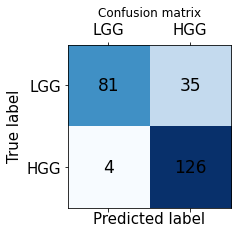

In [17]:
evaluate_model(model, test_image_gen)

In [18]:
analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)

In [19]:
images, y = next(test_image_gen)
images_seg, y_seg = next(test_seg_gen)

In [20]:
a = analyzer.analyze(images)

In [21]:
a['input_layer'].shape

(32, 240, 240, 3)

In [22]:
def postprocess_lrp(analyzed_image):
    analyzed_image = analyzed_image.sum(axis=np.argmax(np.asarray(analyzed_image.shape) == 3))
    analyzed_image /= np.max(np.abs(analyzed_image))
    return analyzed_image

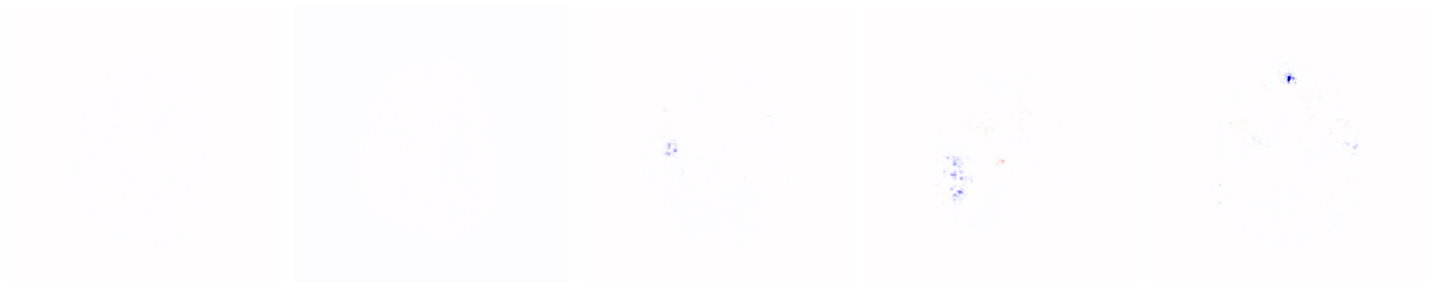

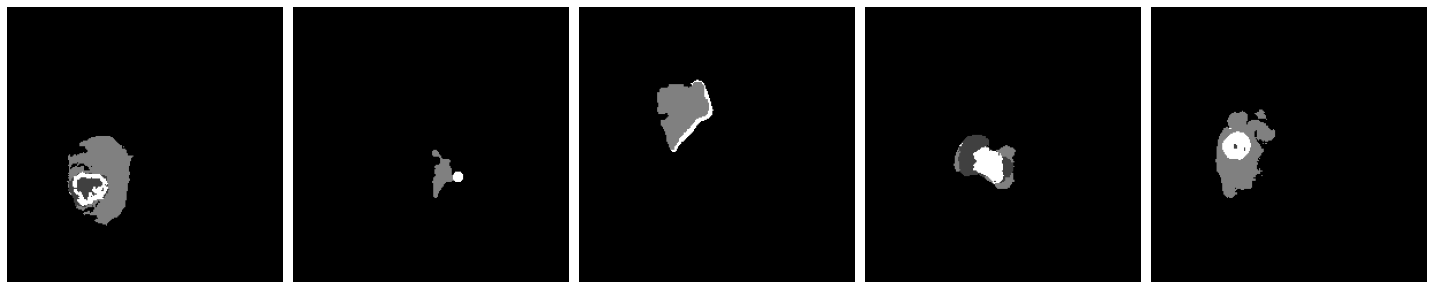

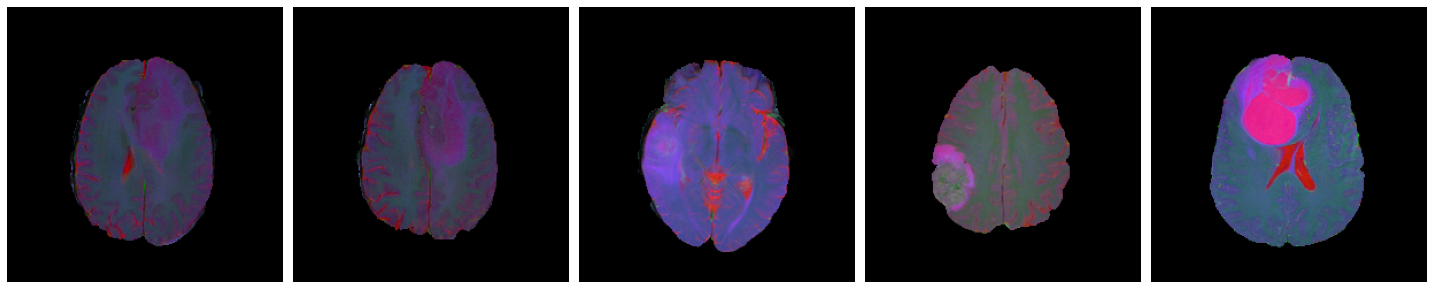

In [25]:
visualization.plot_analysis_images(postprocess_lrp(a['input_layer'][5:10]))
visualization.plot_gray_images(images_seg[5:10])
visualization.plot_rgb_images(images[5:10])